In [1]:
# prompt: define all_video_file_paths which contain file path of all the videos in the directory /content/UCF101_subset

import os
all_video_file_paths = []
for root, _, files in os.walk("d2/Anomaly-Multiclass-Dataset"):
    for file in files:
        if file.endswith((".mp4", ".avi")):  # Add other video extensions if needed
            all_video_file_paths.append(os.path.join(root, file))

In [2]:
model_dataset = "Videomae-d2"
dataset_root_path = "d2/Anomaly-Multiclass-Dataset"

In [3]:
all_video_file_paths

['d2/Anomaly-Multiclass-Dataset/train/Robbery/Robbery127_x264.mp4',
 'd2/Anomaly-Multiclass-Dataset/train/Robbery/Robbery136_x264.mp4',
 'd2/Anomaly-Multiclass-Dataset/train/Robbery/Robbery138_x264.mp4',
 'd2/Anomaly-Multiclass-Dataset/train/Robbery/Robbery030_x264.mp4',
 'd2/Anomaly-Multiclass-Dataset/train/Robbery/Robbery094_x264.mp4',
 'd2/Anomaly-Multiclass-Dataset/train/Robbery/Robbery035_x264.mp4',
 'd2/Anomaly-Multiclass-Dataset/train/Robbery/Robbery025_x264.mp4',
 'd2/Anomaly-Multiclass-Dataset/train/Robbery/Robbery144_x264.mp4',
 'd2/Anomaly-Multiclass-Dataset/train/Robbery/Robbery105_x264.mp4',
 'd2/Anomaly-Multiclass-Dataset/train/Robbery/Robbery130_x264.mp4',
 'd2/Anomaly-Multiclass-Dataset/train/Robbery/Robbery058_x264.mp4',
 'd2/Anomaly-Multiclass-Dataset/train/Robbery/Robbery107_x264.mp4',
 'd2/Anomaly-Multiclass-Dataset/train/Robbery/Robbery071_x264.mp4',
 'd2/Anomaly-Multiclass-Dataset/train/Robbery/Robbery014_x264.mp4',
 'd2/Anomaly-Multiclass-Dataset/train/Robbery/Ro

In [4]:
class_labels = sorted({str(path).split("/")[3] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism'].


There are 10 unique classes. For each class, there are 30 videos in the training set.

## Load a model to fine-tune

Instantiate a video classification model from a pretrained checkpoint and its associated image processor. The model's encoder comes with pre-trained parameters, and the classification head is randomly initialized. The image processor will come in handy when writing the preprocessing pipeline for our dataset.

In [5]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from transformers import AutoImageProcessor, TimesformerForVideoClassification
from transformers import  VivitConfig,VivitForVideoClassification

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ckpt = "MCG-NJU/videomae-base"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)

model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


#model = TimesformerForVideoClassification.from_pretrained("facebook/timesformer-base-finetuned-k400",
#                                                          label2id=label2id,
#                                                          id2label=id2label,
#                                                          ignore_mismatched_sizes=True
#                                                          )

#model = VivitForVideoClassification.from_pretrained(
#    "google/vivit-b-16x2-kinetics400",
#    label2id=label2id,
#    id2label=id2label,
#    ignore_mismatched_sizes=True)
model.to(device)


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VideoMAEForVideoClassification(
  (videomae): VideoMAEModel(
    (embeddings): VideoMAEEmbeddings(
      (patch_embeddings): VideoMAEPatchEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
    )
    (encoder): VideoMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x VideoMAELayer(
          (attention): VideoMAESdpaAttention(
            (attention): VideoMAESdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): VideoMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VideoMAEIntermediate(
            (den

While the model is loading, you might notice the following warning:

```bash
Some weights of the model checkpoint at MCG-NJU/videomae-base were not used when initializing VideoMAEForVideoClassification: [..., 'decoder.decoder_layers.1.attention.output.dense.bias', 'decoder.decoder_layers.2.attention.attention.key.weight']
- This IS expected if you are initializing VideoMAEForVideoClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing VideoMAEForVideoClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```

The warning is telling us we are throwing away some weights (e.g. the weights and bias of the `classifier` layer) and randomly initializing some others (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

**Note** that [this checkpoint](https://huggingface.co/MCG-NJU/videomae-base-finetuned-kinetics) leads to better performance on this task as the checkpoint was obtained fine-tuning on a similar downstream task having considerable domain overlap. You can check out [this checkpoint](https://huggingface.co/sayakpaul/videomae-base-finetuned-kinetics-finetuned-ucf101-subset) which was obtained by fine-tuning `MCG-NJU/videomae-base-finetuned-kinetics`.

## Prepare the datasets for training

In [6]:
# prompt: no module named torchvision.transforms.functional_tensor'



In [7]:

import pytorchvideo.data
import torchvision

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

For the training dataset transformations, use a combination of uniform temporal subsampling, pixel normalization, random cropping, and random horizontal flipping. For the validation and evaluation dataset transformations, keep the same transformation chain except for random cropping and horizontal flipping. To learn more about the details of these transformations check out the [official documentation of PyTorchVideo](https://pytorchvideo.org).  

Use the `image_processor` associated with the pre-trained model to obtain the following information:

* Image mean and standard deviation with which the video frame pixels will be normalized.
* Spatial resolution to which the video frames will be resized.

Start by defining some constants.

In [8]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

Now, define the dataset-specific transformations and the datasets respectively. Starting with the training set:

In [9]:
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

The same sequence of workflow can be applied to the validation and evaluation sets:

In [10]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

**Note**: The above dataset pipelines are taken from the [official PyTorchVideo example](https://pytorchvideo.org/docs/tutorial_classification#dataset). We're using the [`pytorchvideo.data.Ucf101()`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.Ucf101) function because it's tailored for the UCF-101 dataset. Under the hood, it returns a [`pytorchvideo.data.labeled_video_dataset.LabeledVideoDataset`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.LabeledVideoDataset) object. `LabeledVideoDataset` class is the base class for all things video in the PyTorchVideo dataset. So, if you want to use a custom dataset not supported off-the-shelf by PyTorchVideo, you can extend the `LabeledVideoDataset` class accordingly. Refer to the `data` API [documentation to](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html) learn more. Also, if your dataset follows a similar structure (as shown above), then using the `pytorchvideo.data.Ucf101()` should work just fine.

You can access the `num_videos` argument to know the number of videos in the dataset.

In [11]:
print(train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos)

665 95 190


## Visualize the preprocessed video for better debugging

In [12]:
!pip install imageio


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


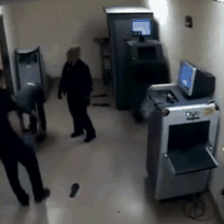

In [13]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/sample_gif.gif" alt="Person playing basketball"/>
</div>

## Train the model

Leverage [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) from  🤗 Transformers for training the model. To instantiate a `Trainer`, you need to define the training configuration and an evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to configure the training. It requires an output folder name, which will be used to save the checkpoints of the model. It also helps sync all the information in the model repository on 🤗 Hub.

Most of the training arguments are self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in this case, you need the unused features ('video' in particular) in order to create `pixel_values` (which is a mandatory key our model expects in its inputs).

In [14]:
import wandb

# Replace with your actual W&B API key
API_KEY = "f7b65d8399dd6262084e166f128e83f97b568e6e"

# Log in to W&B with the API key
wandb.login(key=API_KEY,relogin=True)

# Project details
PROJECT = model_dataset
MODEL_NAME = model_dataset
DATASET = "UCF Anomaly Multiclass Classification"

# Initialize W&B with an increased timeout
wandb.init(
    project=PROJECT,
    tags=[MODEL_NAME, DATASET],
    notes="model training"  # Increase timeout to 300 seconds
)



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anookinskywalker (anookinskywalker-jaypee-institute-of-information-technology). Use `wandb login --relogin` to force relogin


In [109]:
!pip install 'accelerate>={ACCELERATE_MIN_VERSION}'


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [15]:
batch_size = 1

In [16]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = model_dataset
num_epochs = 10

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    eval_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
    fp16=True,
    report_to="wandb"
)

/root/.pyenv/versions/3.10.12/envs/timesformers/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


The dataset returned by `pytorchvideo.data.Ucf101()` doesn't implement the `__len__` method. As such, we must define `max_steps` when instantiating `TrainingArguments`.

Next, you need to define a function to compute the metrics from the predictions, which will use the `metric` you'll load now. The only preprocessing you have to do is to take the argmax of our predicted logits:

In [112]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [17]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

**A note on evaluation**:

In the [VideoMAE paper](https://arxiv.org/abs/2203.12602), the authors use the following evaluation strategy. They evaluate the model on several clips from test videos and apply different crops to those clips and report the aggregate score. However, in the interest of simplicity and brevity, we don't consider that in this tutorial.

Also, define a `collate_fn`, which will be used to batch examples together. Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [18]:
def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then you just pass all of this along with the datasets to `Trainer`:

In [19]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/tmp/ipykernel_1905/3087471478.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
max_steps is given, it will override any value given in num_train_epochs


You might wonder why you passed along the `image_processor` as a tokenizer when you preprocessed the data already. This is only to make sure the image processor configuration file (stored as JSON) will also be uploaded to the repo on the Hub.

Now fine-tune our model by calling the `train` method:

In [20]:
import torch

In [21]:
train_results = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
0,2.553300,2.514310,0.113454
1,2.528900,2.501448,0.141187
2,2.037000,2.479755,0.172358
3,2.593500,2.493537,0.180380
4,1.779000,2.357829,0.232409
5,1.898800,2.365891,0.254641
6,2.226800,2.363196,0.240202
7,1.519200,2.407875,0.245244
8,2.032700,2.480444,0.277332
9,1.588500,2.440537,0.281687


Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [22]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/skywalker290/Videomae-d2/commit/67f510e07ff5c002cb85cccec70b194b4862990c', commit_message='End of training', commit_description='', oid='67f510e07ff5c002cb85cccec70b194b4862990c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/skywalker290/Videomae-d2', endpoint='https://huggingface.co', repo_type='model', repo_id='skywalker290/Videomae-d2'), pr_revision=None, pr_num=None)

## Inference

Great, now that you have fine-tuned a model, you can use it for inference!

Load a video for inference:

In [90]:
sample_test_video = next(iter(test_dataset))

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/sample_gif_two.gif" alt="Teams playing basketball"/>
</div>

The simplest way to try out your fine-tuned model for inference is to use it in a [`pipeline`](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.VideoClassificationPipeline). Instantiate a `pipeline` for video classification with your model, and pass your video to it:

In [94]:
from transformers import pipeline

video_cls = pipeline(model="skywalker290/VIVIT-d2", device = "cuda")
video_cls("https://huggingface.co/datasets/sayakpaul/ucf101-subset/resolve/main/v_BasketballDunk_g14_c06.avi")

TypeError: 'NoneType' object is not callable

You can also manually replicate the results of the `pipeline` if you'd like.

In [ ]:
def run_inference(model, video):
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)
    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

Now, pass your input to the model and return the `logits`:

```
>>> logits = run_inference(trained_model, sample_test_video["video"])
```

Decoding the `logits`, we get:

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

# Predicted class: BasketballDunk